<a href="https://colab.research.google.com/github/Raghad-Odwan/DermAI_Final_Training/blob/main/DermAI_FinalTraining_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DermAI: Final Model Training**

              Palestine Technical University - Kadoorie
                
              Department of Computer Systems Engineering

              DermAI: Intelligent Skin Cancer Detection Using Convolutional     Neural Network & Transfer Learning Architectures


### **About this notebook**

This notebook performs the final training stage of the DermAI skin lesion classification model.

After completing the cross-validation phase and identifying the best-performing fold, this notebook trains a final production model using the entire dataset (19,505 images). The goal is to leverage all available data to produce the most accurate and stable version of the model for deployment.

#### **Main Functions of This Notebook**

1. Load the best fold model trained during cross-validation.

2. Automatically detect whether the model uses softmax (2-class) or sigmoid (binary) architecture.

3. Freeze all layers and fine-tune the last 40 layers for targeted improvement.

4. Prepare the full dataset with advanced augmentation and a small validation split for monitoring.

5. Configure training using AdamW/Adam with optimized learning rate and regularization.

6. Track performance using validation accuracy, early stopping, and learning rate scheduling.

7. Save all outputs, including:

* Best model (final_model_best.keras)

* Full final model (final_model_complete.keras)

* Training logs and summary

* Accuracy/Loss curves

##### **Purpose of This Notebook**

This final training stage produces the single final model that will be used for:

* Deployment

* Grad-CAM visualization

* Integration into the DermAI system

It applies the hyperparameters validated during the cross-validation phase and ensures the model benefits from training on the full dataset.

###  



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>

___________________________________________________________________________________________________

## **Part One: Dataset Load & prepare**

In [4]:
# Import required libraries
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Configuration

# Paths define
BASE_DIR = "/content/drive/MyDrive/Dataset/Dataset"
METADATA_PATH = "/content/drive/MyDrive/ai/data/df_metadata.csv"
MODEL_SAVE_DIR = "/content/drive/MyDrive/DermAI_FinalTraining_Model"
PLOTS_DIR = "/content/drive/MyDrive/DermAI_Final_Results_Plots"

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print(f"\nConfiguration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Model Directory: {MODEL_SAVE_DIR}")


Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Max Epochs: 50
  Model Directory: /content/drive/MyDrive/DermAI_FinalTraining_Model


In [7]:
# Load and Inspect Dataset
df = pd.read_csv(METADATA_PATH)
print(f"\nTotal samples: {len(df):,}")
print(f"\nClass distribution:")
print(df['label'].value_counts())


Total samples: 19,501

Class distribution:
label
benign       13291
malignant     6210
Name: count, dtype: int64


In [8]:
# Verify file existence
missing_files = []
for idx, row in df.iterrows():
    if not os.path.exists(row['path']):
        missing_files.append(row['path'])

if missing_files:
    print(f"\nWarning: {len(missing_files)} files not found")
else:
    print("\nAll image files verified successfully")


All image files verified successfully


##### Data Split

In [9]:
# Data Split: 80% Train / 10% Val / 10% Test

# Load df and prepare X, y for training (these lines are moved/duplicated from _emNvBXnEcr0 for immediate execution)
df = pd.read_csv(METADATA_PATH)
X = df['path'].values
y = df['label_idx'].values

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=RANDOM_STATE
)

# Second split: 80% train, 10% val (from remaining 90%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=RANDOM_STATE
)

train_df = pd.DataFrame({'path': X_train, 'label_idx': y_train})
val_df = pd.DataFrame({'path': X_val, 'label_idx': y_val})
test_df = pd.DataFrame({'path': X_test, 'label_idx': y_test})

print(f"\nTrain set: {len(train_df):,} samples")
print(f"  Benign: {(train_df['label_idx']==0).sum():,}")
print(f"  Malignant: {(train_df['label_idx']==1).sum():,}")

print(f"\nValidation set: {len(val_df):,} samples")
print(f"  Benign: {(val_df['label_idx']==0).sum():,}")
print(f"  Malignant: {(val_df['label_idx']==1).sum():,}")

print(f"\nTest set: {len(test_df):,} samples")
print(f"  Benign: {(test_df['label_idx']==0).sum():,}")
print(f"  Malignant: {(test_df['label_idx']==1).sum():,}")


Train set: 15,600 samples
  Benign: 10,632
  Malignant: 4,968

Validation set: 1,950 samples
  Benign: 1,329
  Malignant: 621

Test set: 1,951 samples
  Benign: 1,330
  Malignant: 621


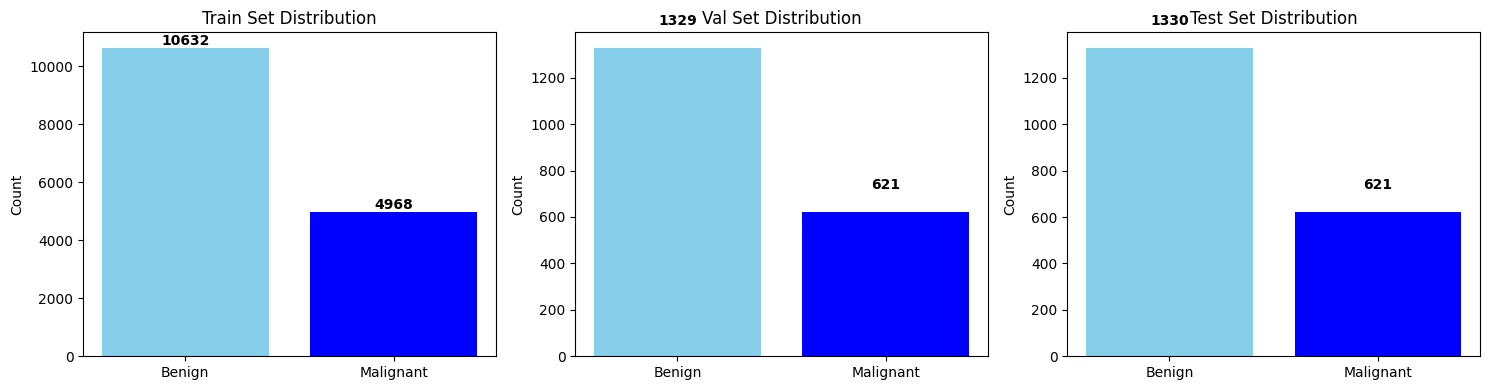

In [10]:
# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, data) in zip(axes, [('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    counts = data['label_idx'].value_counts().sort_index()
    ax.bar(['Benign', 'Malignant'], counts.values, color=['skyblue', 'blue'])
    ax.set_title(f'{name} Set Distribution')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts.values):
        ax.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'data_split_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

#####      


Note (Why the split is done this way)

The dataset is split in two stages to maintain perfect class balance using stratified splitting.
First, 10% of the full dataset is reserved as the test set for unbiased final evaluation.
Then, 10% of the remaining 90% (i.e., 0.1111) is taken as the validation set, giving an exact 80% train / 10% validation / 10% test split while preserving the benign/malignant distribution in all subsets.

In [11]:
# Class Weight Balancing
classes = np.unique(y_train)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights_array)}

print(f"\nClass weights (for training): {class_weight}")


Class weights (for training): {0: 0.7336343115124153, 1: 1.570048309178744}




---



## **Part Two: Model Training and Evaluation**

In [12]:
# Import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
)
import math
import os
import seaborn as sns
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

**Data Generators**

In [13]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label_idx',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_STATE
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label_idx',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
val_steps = math.ceil(len(val_df) / BATCH_SIZE)

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {val_steps}")

Found 15600 validated image filenames.
Found 1950 validated image filenames.

Steps per epoch: 488
Validation steps: 61




---



In [14]:
# Load Best Cross-Validation Model
#  to initialize final fine-tuning.
BEST_CV_MODEL_PATH = "/content/drive/MyDrive/DermAI_models_resnet/best_resnet50_fold2.keras"
if not os.path.exists(BEST_CV_MODEL_PATH):
    print(f"Warning: Best CV model not found at {BEST_CV_MODEL_PATH}")
    print("Building new model from scratch...")

Building new model from scratch...




---



**Model Building**

In [15]:
# Build ResNet50 binary classifier with fine-tuning of the last N layers

if os.path.exists(BEST_CV_MODEL_PATH):
    print(f"Loading model from: {BEST_CV_MODEL_PATH}")
    model = load_model(BEST_CV_MODEL_PATH)
else:
    print("BEST_CV_MODEL_PATH not found, building model from scratch.")
    def build_resnet_binary(input_shape=(224,224,3), unfreeze_last_n=40):
        base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

        for layer in base.layers:
            layer.trainable = False

        for layer in base.layers[-unfreeze_last_n:]:
            if 'batch_normalization' not in layer.name:
                layer.trainable = True

        x = GlobalAveragePooling2D()(base.output)
        x = Dropout(0.4)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

        model = Model(inputs=base.input, outputs=outputs)
        return model

    model = build_resnet_binary(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), unfreeze_last_n=40)

# Recompile with final training settings
model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
print("\nModel compiled successfully")
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

BEST_CV_MODEL_PATH not found, building model from scratch.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model compiled successfully
Total parameters: 24,637,313
Trainable parameters: 16,881,409


In [16]:
# Setup Callbacks
best_model_path = os.path.join(MODEL_SAVE_DIR, "final_model_best.keras")
final_model_path = os.path.join(MODEL_SAVE_DIR, "final_model_complete.keras")
csv_log_path = os.path.join(MODEL_SAVE_DIR, "training_log.csv")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    ModelCheckpoint(
        best_model_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger(csv_log_path, append=False)
]

print(f"\nCallbacks configured:")
print(f"  Early stopping: patience=8, monitor=val_recall")
print(f"  Model checkpoint: {best_model_path}")
print(f"  Learning rate reduction: factor=0.5, patience=3")
print(f"  Training log: {csv_log_path}")


Callbacks configured:
  Early stopping: patience=8, monitor=val_recall
  Model checkpoint: /content/drive/MyDrive/DermAI_FinalTraining_Model/final_model_best.keras
  Learning rate reduction: factor=0.5, patience=3
  Training log: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_log.csv




---



In [17]:
# Train Final Model
start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time

print(f"\nTraining completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {training_duration}")

Training started at: 2025-12-10 16:57:14
Epoch 1/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7359 - auc: 0.8050 - loss: 0.5263 - precision: 0.5694 - recall: 0.7059 
Epoch 1: val_loss improved from inf to 0.43667, saving model to /content/drive/MyDrive/DermAI_FinalTraining_Model/final_model_best.keras
488/488 ━━━━━━━━━━━━━━━━━━━━ 5979s 12s/step - accuracy: 0.7360 - auc: 0.8050 - loss: 0.5262 - precision: 0.5695 - recall: 0.7060 - val_accuracy: 0.7821 - val_auc: 0.8835 - val_loss: 0.4367 - val_precision: 0.8182 - val_recall: 0.4058 - learning_rate: 1.0000e-05
Epoch 2/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7814 - auc: 0.8766 - loss: 0.4374 - precision: 0.6290 - recall: 0.7930
Epoch 2: val_loss did not improve from 0.43667
488/488 ━━━━━━━━━━━━━━━━━━━━ 283s 579ms/step - accuracy: 0.7814 - auc: 0.8766 - loss: 0.4374 - precision: 0.6290 - recall: 0.7930 - val_accuracy: 0.7646 - val_auc: 0.8849 - val_loss: 0.4543 - val_precision: 0.5902 - val_recall: 0.8535 -

In [18]:
# Save final model state
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Final model saved to: /content/drive/MyDrive/DermAI_FinalTraining_Model/final_model_complete.keras




---



##### **Load Best Model and Evaluate**

In [19]:
# evaluation on validation set
print("Evaluation on Validation set")
best_model = load_model(best_model_path)

val_gen_eval = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label_idx',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

preds_prob = best_model.predict(val_gen_eval, steps=val_steps, verbose=1)
preds_prob = preds_prob.ravel()
preds = (preds_prob > 0.5).astype(int)
true = val_df['label_idx'].values[:len(preds)]

acc = accuracy_score(true, preds)
prec = precision_score(true, preds, zero_division=0)
rec = recall_score(true, preds, zero_division=0)
f1 = f1_score(true, preds, zero_division=0)

print(f"\nValidation Performance (threshold=0.5):")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true, preds, target_names=['Benign', 'Malignant'], zero_division=0))

Evaluation on Validation set
Found 1950 validated image filenames.
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step

Validation Performance (threshold=0.5):
  Accuracy:  0.8118
  Precision: 0.6862
  Recall:    0.7536
  F1-Score:  0.7183

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.84      0.86      1329
   Malignant       0.69      0.75      0.72       621

    accuracy                           0.81      1950
   macro avg       0.78      0.80      0.79      1950
weighted avg       0.82      0.81      0.81      1950



In [20]:
# evaluation on test set
print("Evaluation on Test set")

test_gen_eval = val_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label_idx',
    target_size=IMG_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_steps = math.ceil(len(test_df) / BATCH_SIZE)

test_preds_prob = best_model.predict(test_gen_eval, steps=test_steps, verbose=1)
test_preds_prob = test_preds_prob.ravel()
test_preds = (test_preds_prob > 0.5).astype(int)
test_true = test_df['label_idx'].values[:len(test_preds)]

test_acc = accuracy_score(test_true, test_preds)
test_prec = precision_score(test_true, test_preds, zero_division=0)
test_rec = recall_score(test_true, test_preds, zero_division=0)
test_f1 = f1_score(test_true, test_preds, zero_division=0)

print(f"\nTest Performance (threshold=0.5):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print("\nTest Classification Report:")
print(classification_report(test_true, test_preds, target_names=['Benign', 'Malignant'], zero_division=0))

Evaluation on Test set
Found 1951 validated image filenames.
61/61 ━━━━━━━━━━━━━━━━━━━━ 587s 10s/step

Test Performance (threshold=0.5):
  Accuracy:  0.8278
  Precision: 0.7136
  Recall:    0.7665
  F1-Score:  0.7391

Test Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.86      0.87      1330
   Malignant       0.71      0.77      0.74       621

    accuracy                           0.83      1951
   macro avg       0.80      0.81      0.81      1951
weighted avg       0.83      0.83      0.83      1951





---



#####  **Generating Plots**

In [21]:
# Define base model directory
MODEL_SAVE_DIR = "/content/drive/MyDrive/DermAI_FinalTraining_Model"

# Create plots subfolder inside the model directory
plots_dir = os.path.join(MODEL_SAVE_DIR, "training_results_plots")
os.makedirs(plots_dir, exist_ok=True)

print(f"Plots will be saved to: {plots_dir}")

Plots will be saved to: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots


In [22]:
from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/DermAI_FinalTraining_Model/final_model_best.keras"
model = load_model(best_model_path)
print("Model loaded successfully!")


Model loaded successfully!


**Training Curves**

In [23]:
# Plot training and validation accuracy/loss curves
def plot_training_curves(history, save_dir=plots_dir):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#000099')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#3366FF')
    plt.title('Model Accuracy During Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='#000099')
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#3366FF')
    plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'training_curves.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")

**Confusion Matrix**

In [24]:
# Plot confusion matrix for any dataset
""" Args:
        true: true labels
        preds: predicted labels
        dataset_name: 'Validation' or 'Test' or 'Final' """

def plot_confusion_matrix(true, preds, dataset_name='Validation', save_dir=plots_dir):
    cm = confusion_matrix(true, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Benign', 'Malignant'],
        yticklabels=['Benign', 'Malignant'],
        cbar_kws={'label': 'Count'},
        annot_kws={'size': 20}
    )
    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=14)

    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = (cm[i, j] / total) * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=14, color='gray')

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'confusion_matrix_{dataset_name.lower()}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")

**ROC Curve**

In [25]:
# Plot ROC curve for any dataset
""" Args:
        true: true labels
        prob: predicted probabilities
        dataset_name: 'Validation' or 'Test' or 'Final' """

def plot_roc_curve(true, prob, dataset_name='Validation', save_dir=plots_dir):

    fpr, tpr, thresholds = roc_curve(true, prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#000099', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='#3366FF', lw=2, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title(f'ROC Curve - {dataset_name} Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'roc_curve_{dataset_name.lower()}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")

**Validation vs Test Comparison**

In [39]:
# Compare validation and test performance side by side
""" Args:
        val_metrics: dict with keys ['accuracy', 'precision', 'recall', 'f1']
        test_metrics: dict with keys ['accuracy', 'precision', 'recall', 'f1'] """

def plot_val_vs_test_comparison(val_metrics, test_metrics, save_dir=plots_dir):
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    val_values = [val_metrics['accuracy'], val_metrics['precision'],
                  val_metrics['recall'], val_metrics['f1']]
    test_values = [test_metrics['accuracy'], test_metrics['precision'],
                   test_metrics['recall'], test_metrics['f1']]

    x = np.arange(len(metrics_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, val_values, width, label='Validation',
               color='#000099', edgecolor='#0000CC', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_values, width, label='Test',
               color='skyblue', edgecolor='skyblue', linewidth=1.5)

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Validation vs Test Performance Comparison',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend(fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'validation_vs_test_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


**Combined ROC Curves**

In [40]:
# Plot validation and test ROC curves on the same figure
def plot_combined_roc_curves(val_true, val_prob, test_true, test_prob, save_dir=plots_dir):
    # Calculate ROC for validation
    val_fpr, val_tpr, _ = roc_curve(val_true, val_prob)
    val_auc = auc(val_fpr, val_tpr)

    # Calculate ROC for test
    test_fpr, test_tpr, _ = roc_curve(test_true, test_prob)
    test_auc = auc(test_fpr, test_tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(val_fpr, val_tpr, color='#1565C0', lw=2.5, label=f'Validation (AUC = {val_auc:.3f})')
    plt.plot(test_fpr, test_tpr, color='#42A5F5', lw=2.5, label=f'Test (AUC = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='#90CAF9', lw=2, linestyle='--', alpha=0.6)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves: Validation vs Test', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'roc_curves_combined.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")



---



**Metrics Summary**

In [41]:
# Plot bar chart of all metrics
def plot_metrics_summary(metrics_dict, dataset_name='Test', save_dir=plots_dir):
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        metrics_dict['accuracy'],
        metrics_dict['precision'],
        metrics_dict['recall'],
        metrics_dict['f1']
    ]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics_names, metrics_values, color=['#E3F2FD', '#90CAF9', '#42A5F5', '#1E88E5'])
    plt.ylim([0, 1.5])
    plt.ylabel('Score', fontsize=12)
    plt.title(f'{dataset_name} Set Performance Metrics',
              fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.02,
                f'{val:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=11)

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'metrics_summary_{dataset_name.lower()}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")


____________________________________________________________
Generating plots
____________________________________________________________


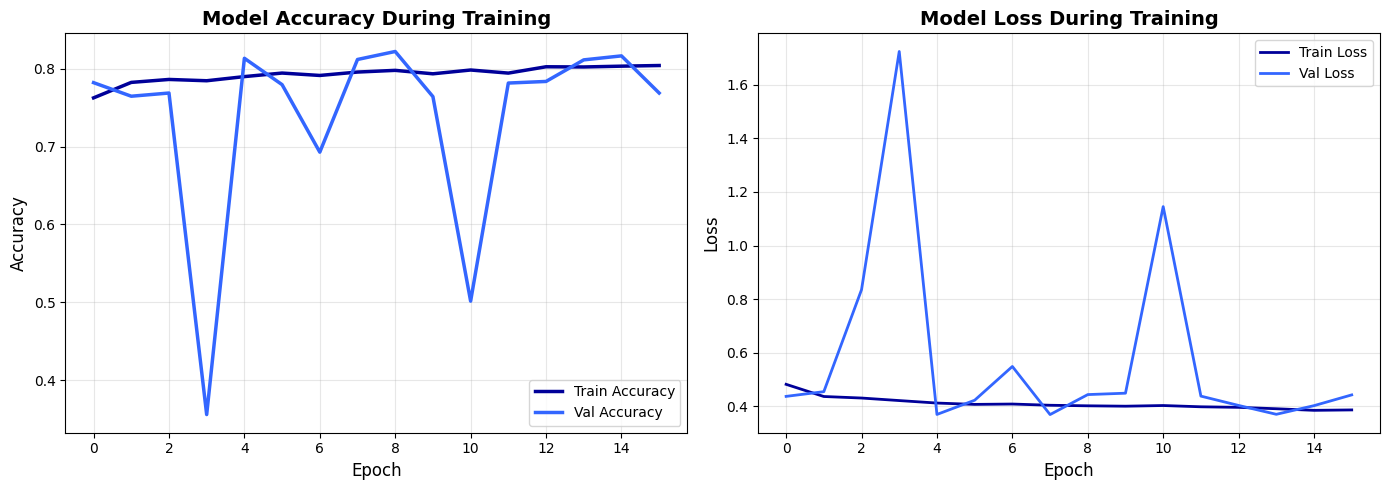

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/training_curves.png

Validation Set Visualizations:


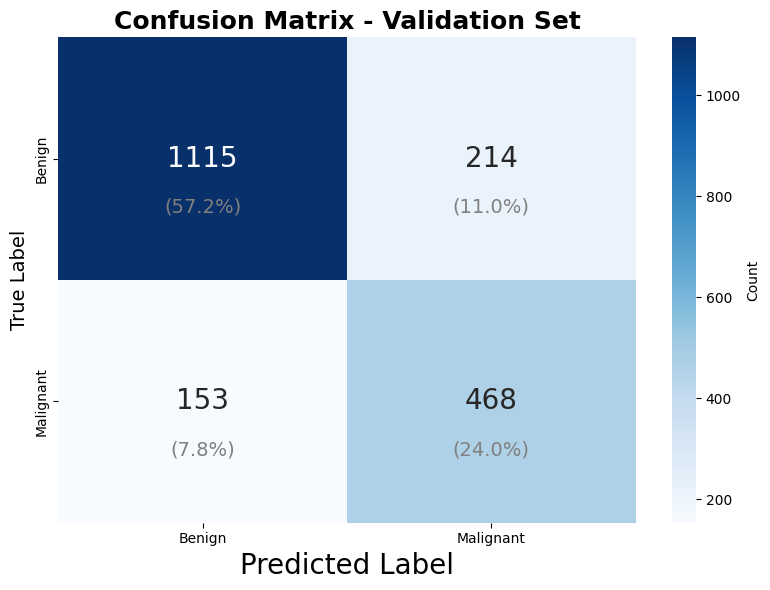

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/confusion_matrix_validation.png


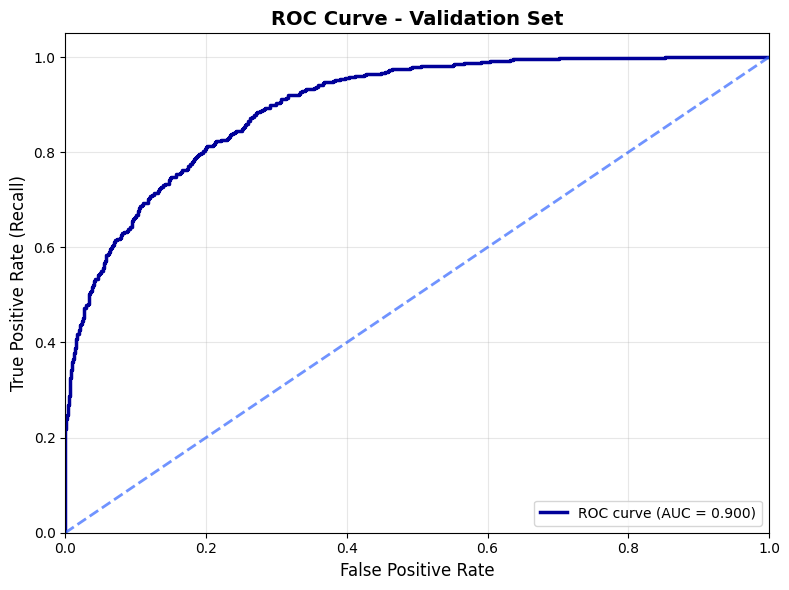

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/roc_curve_validation.png


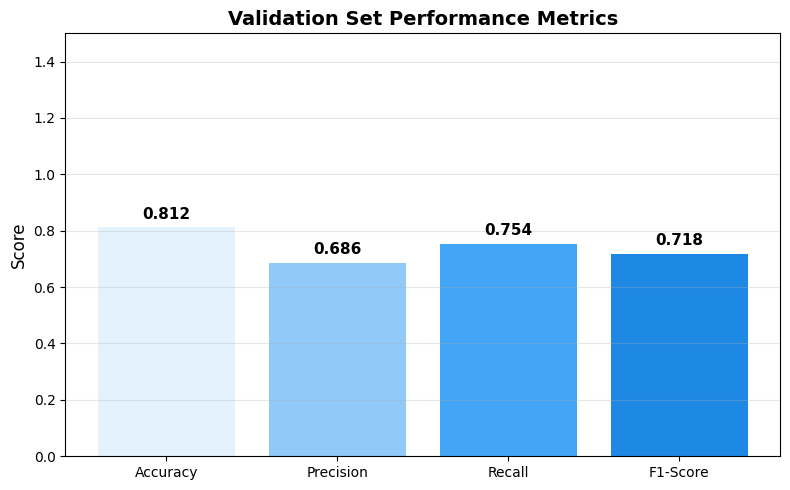

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/metrics_summary_validation.png

Test Set Visualizations:


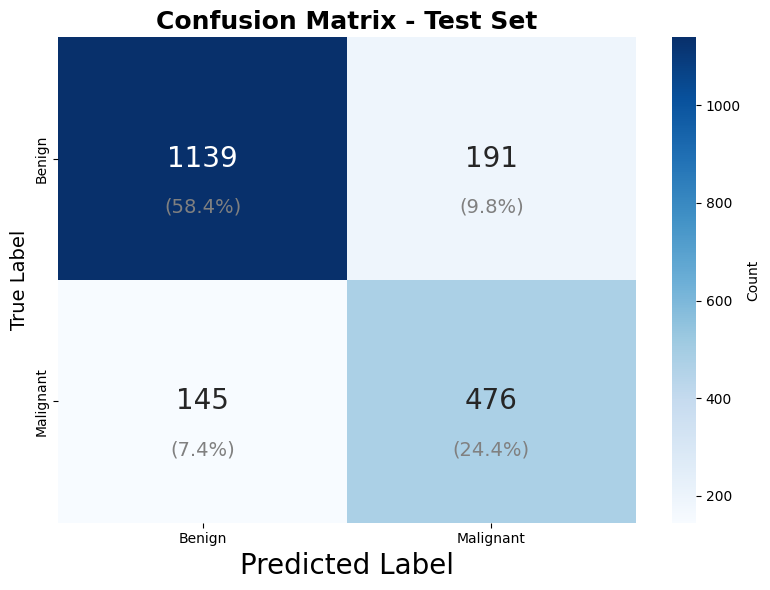

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/confusion_matrix_test.png


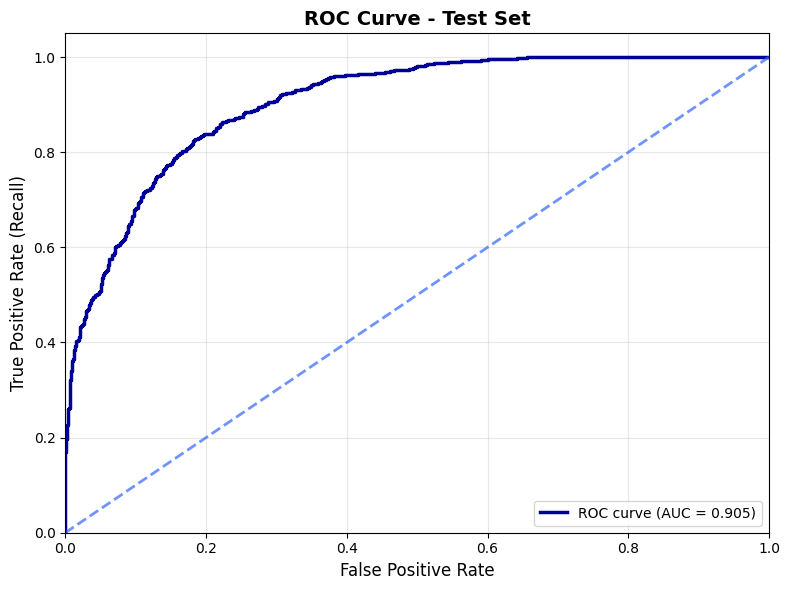

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/roc_curve_test.png


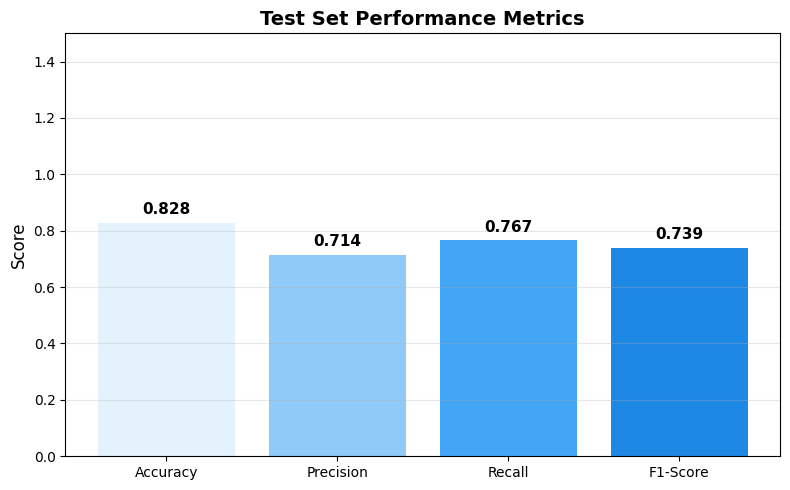

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/metrics_summary_test.png

Comparison Visualizations:


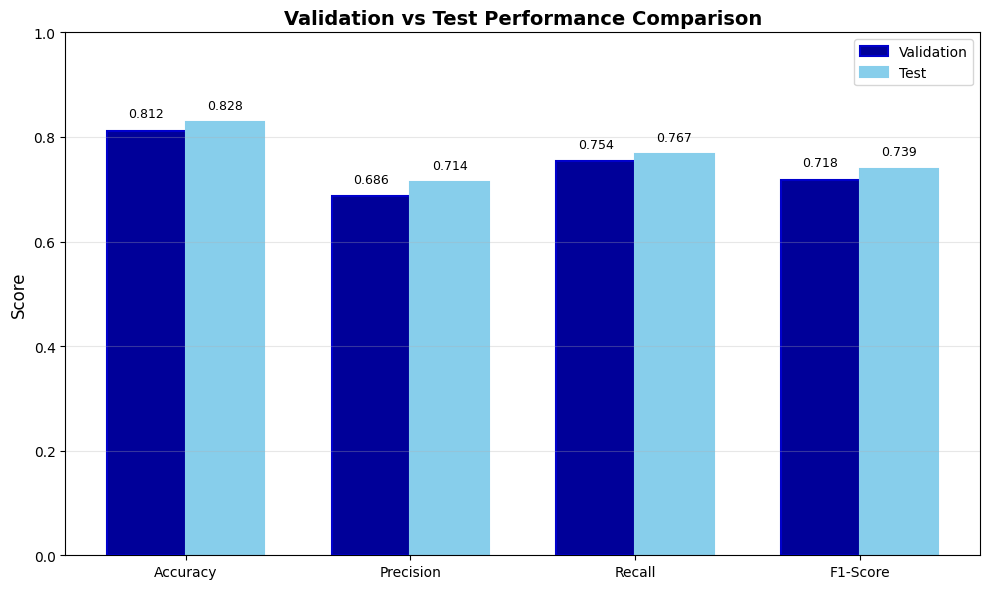

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/validation_vs_test_comparison.png


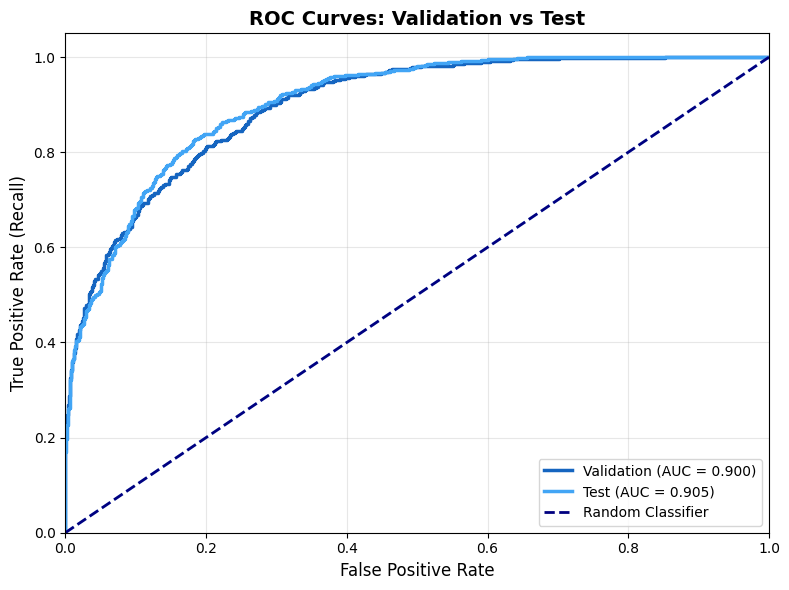

Saved: /content/drive/MyDrive/DermAI_FinalTraining_Model/training_results_plots/roc_curves_combined.png
____________________________________________________________


In [42]:
# Generating plots
print("\n" + "_"*60)
print("Generating plots")
print("_"*60)
# 1. Training curves (from history)
plot_training_curves(history)

# 2. Validation performance
print("\nValidation Set Visualizations:")
plot_confusion_matrix(true, preds, dataset_name='Validation')
plot_roc_curve(true, preds_prob, dataset_name='Validation')

val_metrics = {
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}
plot_metrics_summary(val_metrics, dataset_name='Validation')

# 3. Test performance
print("\nTest Set Visualizations:")
plot_confusion_matrix(test_true, test_preds, dataset_name='Test')
plot_roc_curve(test_true, test_preds_prob, dataset_name='Test')

test_metrics = {
    'accuracy': test_acc,
    'precision': test_prec,
    'recall': test_rec,
    'f1': test_f1
}
plot_metrics_summary(test_metrics, dataset_name='Test')

# 4. Comparison plots
print("\nComparison Visualizations:")
plot_val_vs_test_comparison(val_metrics, test_metrics)
plot_combined_roc_curves(true, preds_prob, test_true, test_preds_prob)
print("_"*60)




---



## **Part Three: Results Analysis and Discussion**